In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

### Metropolitan area

##### Clean data

In [7]:
df = pd.read_csv(r'../data/df_allmetro_all.csv')
# allgemeines unemployment nehmen 

# country column
df['country'] = df['metroreg'].apply (lambda x: x[:2])

# calculate relative crime
df.loc[:, 'crime/population'] = (df['Nr_Crimes'] / df['population']) *1_000_000     # normalizing to per Million 
df.loc[:, 'density'] = df['population'] / df['area'] 
# df.loc[:, 'crime/density'] = df['Nr_Crimes'] / df['density']

# drop na
df.dropna()

# log columns
df.loc[:, 'crime/population_log'] = np.log(df['crime/population'] + 1e-20)  # add small number to avoid log(0)
df.loc[:, 'density_log'] = np.log(df['density'] + 1e-20)
# df.loc[:, 'crime/density_log'] = np.log(df['crime/density'] + 1e-20)
df.loc[:, 'unemp_log'] = np.log(df['unemp per Tsd.'] + 1e-20)   # unemployment per tsd.
df.loc[:, 'gdp_log'] = np.log(df['gdp'] + 1e-20)        # kaufkraftbereinigten gdp nehmen

# drop aggregates
df = df[df['metroreg'].str.len() >= 3]

# choosing youth unemployment & normalized PP standard 
df = df[(df['unit'] == 'PPS_HAB_EU27_2020:Purchasing power standard (PPS, EU27 from 2020), per inhabitant in percentage of the EU27 (from 2020) average')  & (df['dfunemp_sex'] == 'T:Total')]

# get metroreg with area change
df_grouped = df.groupby(['metroreg', 'TIME_PERIOD'])['area'].mean().reset_index()
metroregs_with_area_change = df_grouped.groupby('metroreg').filter(lambda x: x['area'].nunique() > 1)['metroreg'].unique()
list(metroregs_with_area_change)
# choose only metropolitan areas, keep non-metropolitan ones
metroregs_with_area_change = [metroreg for metroreg in metroregs_with_area_change if not metroreg.endswith('NM')]
# drop metroregs with area change
df = df.drop(df[df['metroreg'].isin([metroregs_with_area_change])].index)

df.to_csv(r'../data/normalized_data_no_area_change.csv')

In [3]:
# select year
def select_year(df, year):
    df = df[df['TIME_PERIOD'] == year]
    return df

# group by type of crime
def group_by_iccs(df):
    df = df.groupby(['metroreg', 'iccs_d']).first().reset_index()   
    return df

# plot scatterplot, correlations
def plot_scatterplot(df, x, y):
    for crime_type in df['iccs_d'].unique():
        subset = df[df['iccs_d'] == crime_type]
        plot = sns.scatterplot(x=x, y=y, data=subset)
        m,b = np.polyfit(subset[x], subset[y], 1)
        plot.plot(subset[x], m*subset[x] + b, color = 'red')
        plt.show()
        print(f'Correlation for {crime_type}:\n {subset[[x, y]].corr()}')




In [4]:
df = df.dropna(subset=['unemp_log'])

In [5]:
# select year
df_year = select_year(df, 2019)

# group by type of crime
df_year_grouped = group_by_iccs(df_year)

# plot scatterplot, correlations
# plot_scatterplot(df_year_grouped, 'density_log', 'crime/population_log')
# plot_scatterplot(df_year_grouped, 'unemp per Tsd.', 'crime/density_log')

In [7]:
df_year_grouped.head()

,metroreg,iccs_d,TIME_PERIOD,unit,gdp,area,population,dfunemp_sex,dfunemp_age,unemp per Tsd.,...,metroreg_d,metroreg_type,crime/population,density,crime/density,crime/population_log,density_log,crime/density_log,unemp_log,gdp_log
0,AT001MC,Burglary of private residential premises,2019,EUR_HAB:Euro per inhabitant,47800.0,8817.0,2853903.0,M:Males,Y15-24:From 15 to 24 years,11.4,...,Wien,M,0.001697,323.681865,14.962222,-6.378908,5.779761,2.705529,2.433613,10.774781
1,AT001MC,Intentional homicide,2019,EUR_HAB:Euro per inhabitant,47800.0,8817.0,2853903.0,M:Males,Y15-24:From 15 to 24 years,11.4,...,Wien,M,0.000011,323.681865,0.098863,-11.398462,5.779761,-2.314025,2.433613,10.774781
2,AT001MC,Robbery,2019,EUR_HAB:Euro per inhabitant,47800.0,8817.0,2853903.0,M:Males,Y15-24:From 15 to 24 years,11.4,...,Wien,M,0.000563,323.681865,4.964751,-7.482074,5.779761,1.602363,2.433613,10.774781
3,AT001MC,Theft of a motorized land vehicle,2019,EUR_HAB:Euro per inhabitant,47800.0,8817.0,2853903.0,M:Males,Y15-24:From 15 to 24 years,11.4,...,Wien,M,0.000152,323.681865,1.337733,-8.793460,5.779761,0.290977,2.433613,10.774781
4,AT002M,Burglary of private residential premises,2019,EUR_HAB:Euro per inhabitant,45700.0,3479.0,637532.0,M:Males,Y15-74:From 15 to 74 years,6.0,...,Graz,M,0.001001,183.251509,3.481554,-6.907021,5.210860,1.247479,1.791759,10.729854


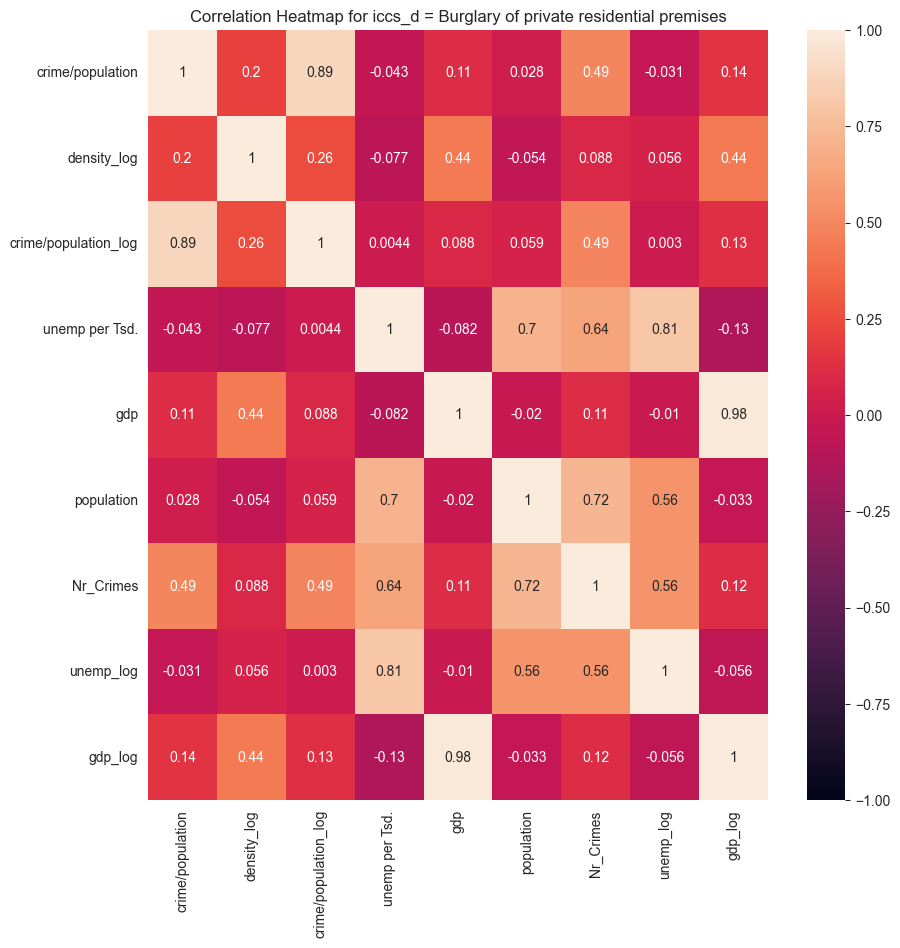

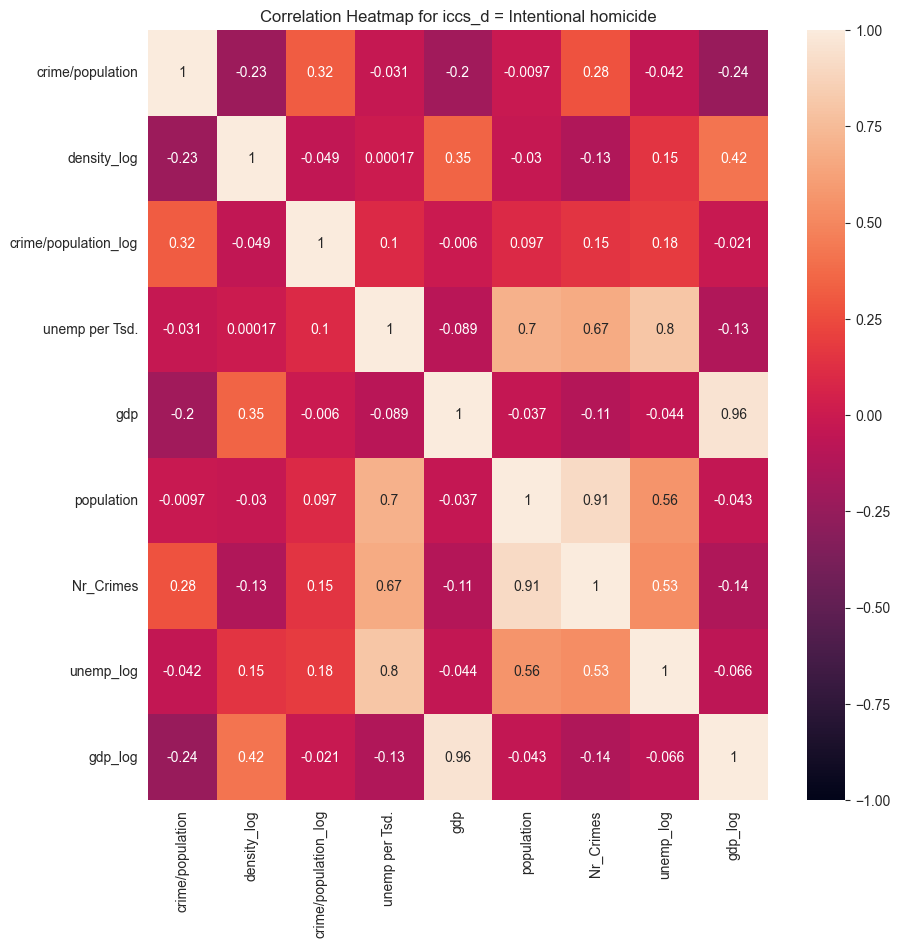

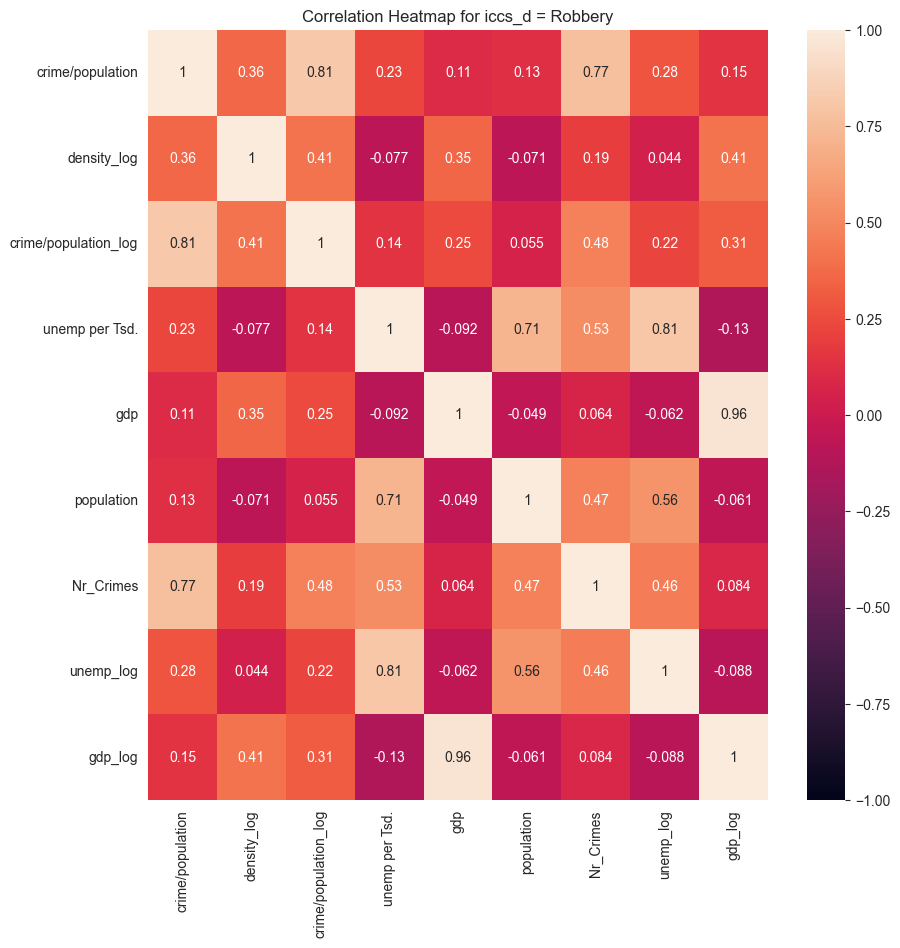

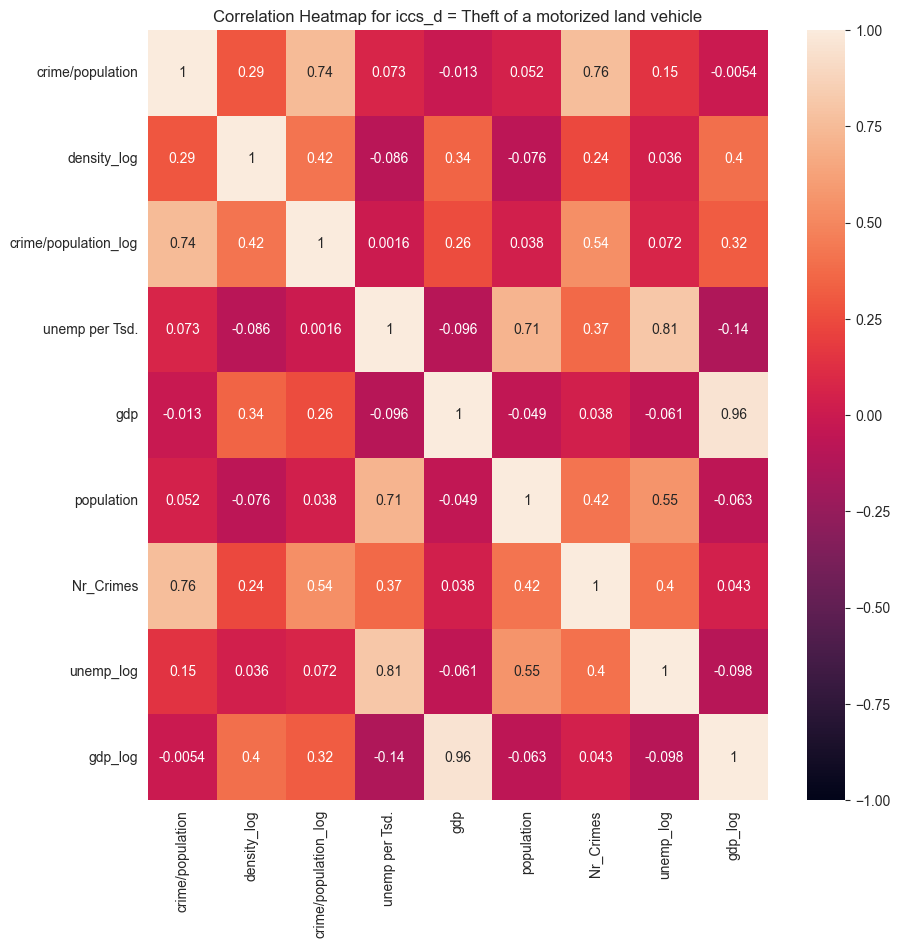

In [53]:
# Loop over the unique 'iccs_d' values in the DataFrame
for iccs in df_year_grouped['iccs_d'].unique():
    # Create a subset of the DataFrame that only contains the rows with the current 'iccs_d' value
    subset = df_year_grouped[df_year_grouped['iccs_d'] == iccs]

    # Calculate the correlation matrix for the subset
    corr = subset[['crime/population', 'density_log', 'crime/population_log',  'unemp per Tsd.', 'gdp', 'population', 'Nr_Crimes', 'unemp_log', 'gdp_log']].corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr, annot=True, vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for iccs_d = {iccs}')
    plt.show()

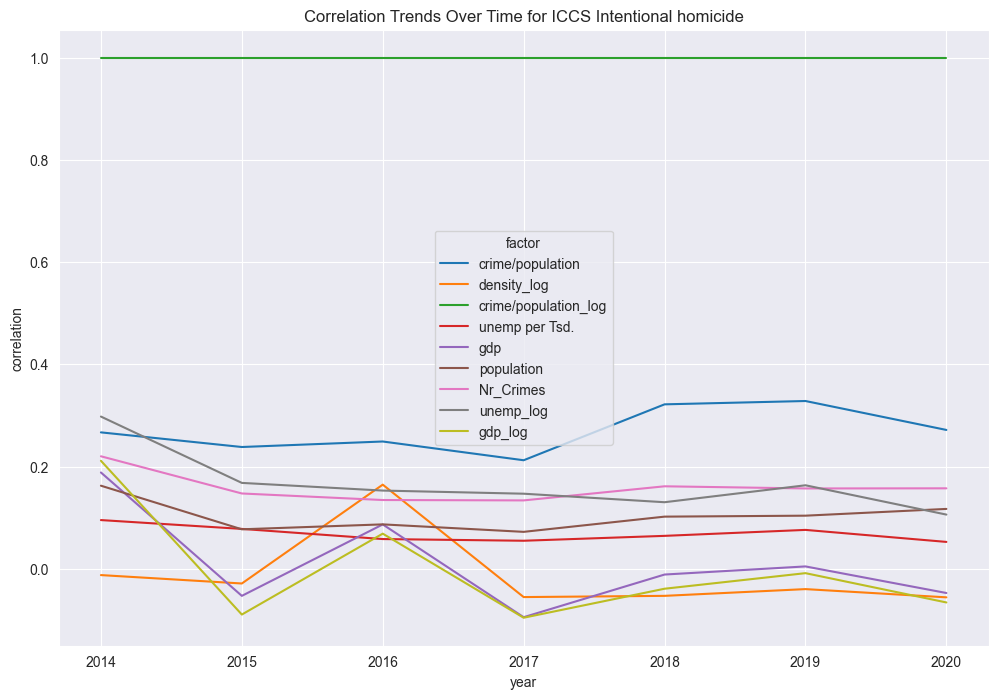

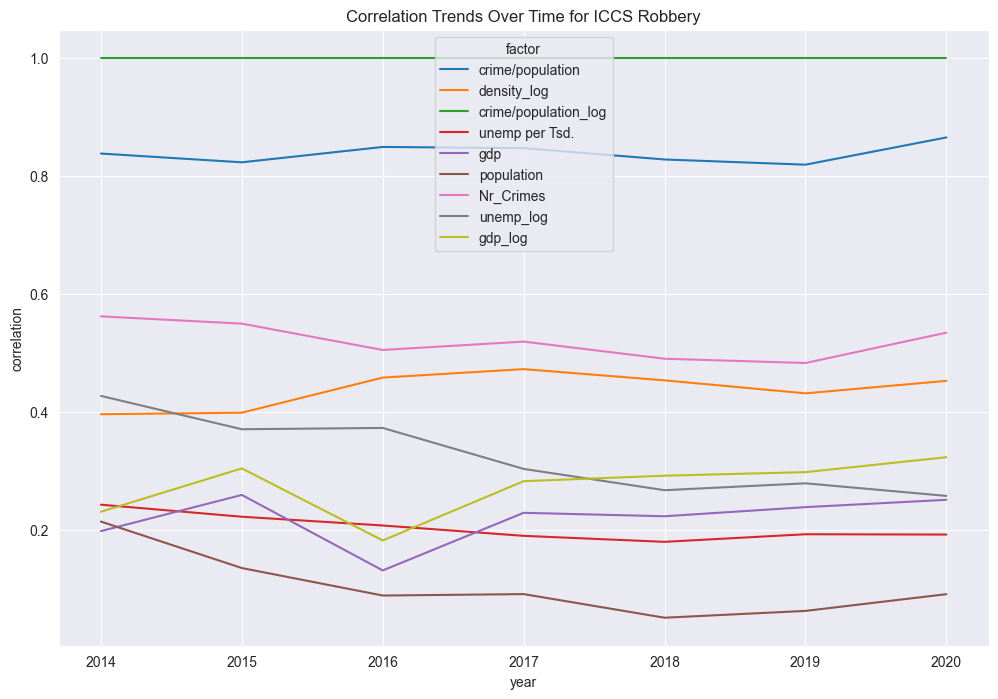

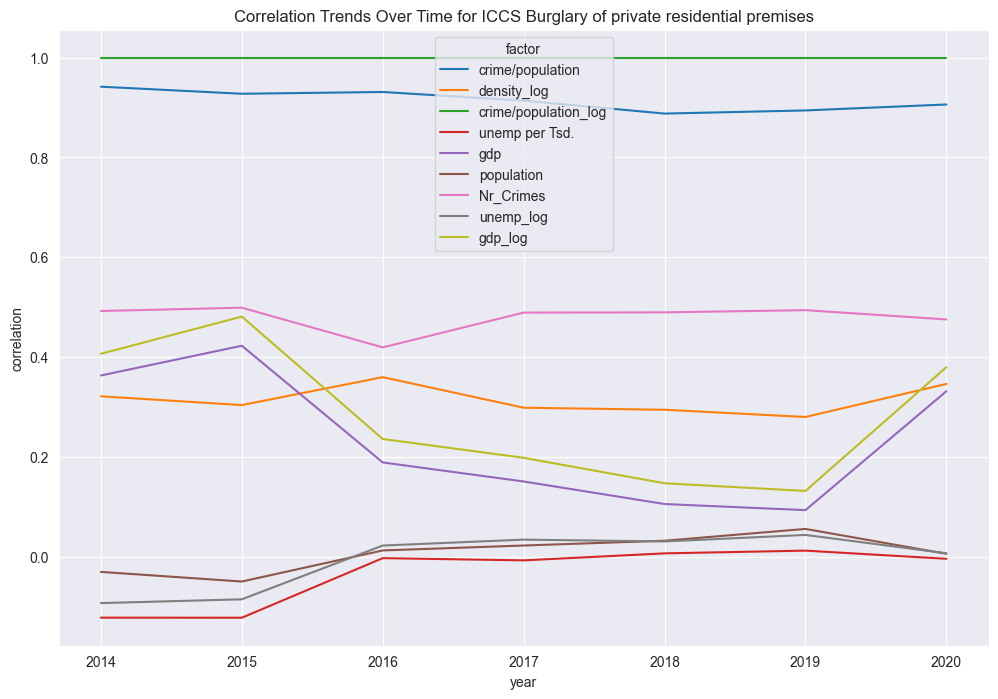

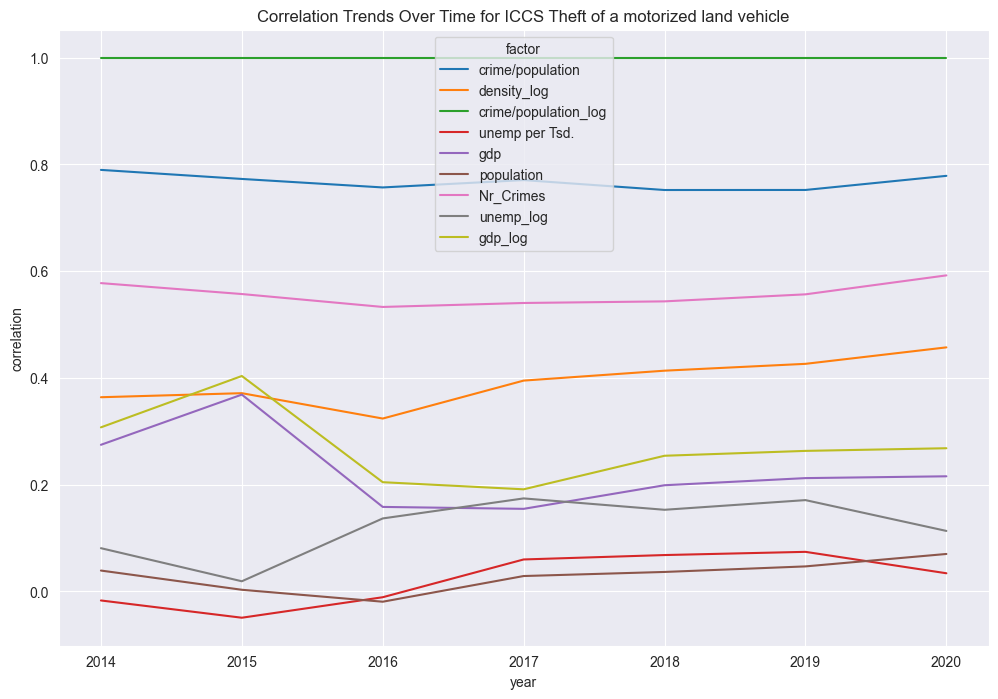

In [55]:
# testing stabilty of correlations over the years

for iccs_value in df['iccs_d'].unique():
    correlation_data = []

    for year in df['TIME_PERIOD'].unique():
        df_year = df[df['TIME_PERIOD'] == year]
        # Create a subset of the DataFrame that only contains the rows with the current 'iccs_d' value
        subset = df_year[df_year['iccs_d'] == iccs_value]
        # Calculate the correlation matrix for the subset
        corr = subset[['crime/population', 'density_log', 'crime/population_log',  
                       'unemp per Tsd.', 'gdp', 'population',
                       'Nr_Crimes', 'unemp_log', 'gdp_log']].corr()
        
        # Iterate over the columns of the correlation matrix
        for factor in corr.columns:
            correlation_data.append({
                'year': year,
                'iccs': iccs_value,
                'factor': factor,
                'correlation': corr.loc[factor, 'crime/population_log']     # target variable
            })

    # Create a DataFrame from the collected correlation data
    correlation_df = pd.DataFrame(correlation_data)

    # Plot using seaborn
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='year', y='correlation', hue='factor', data=correlation_df)
    plt.title(f'Correlation Trends Over Time for ICCS {iccs_value}')
    plt.show()

In [56]:
# regression model using k fold
def regression_model(df, x, y):
    # Reset the index of the DataFrame
    df = df.reset_index(drop=True)
    
    # Split data
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(df)
    
    # Create model
    coefficients = []
    r2_scores = []
    model = LinearRegression()
    
    # Train model
    for train_index, test_index in kf.split(df):
        X_train, X_test = df.iloc[train_index][x], df.iloc[test_index][x]
        y_train, y_test = df.iloc[train_index][y], df.iloc[test_index][y]
        
        model.fit(X_train, y_train)
        
        coefficients.append(model.coef_)
        r2_scores.append(model.score(X_test, y_test))
    
    # Return the trained model
    return np.mean(coefficients), np.mean(r2_scores)

In [58]:
df_year_grouped.dropna()

,metroreg,iccs_d,TIME_PERIOD,unit,gdp,area,population,dfunemp_sex,dfunemp_age,unemp per Tsd.,...,Nr_Crimes,metroreg_d,metroreg_type,country,crime/population,density,crime/population_log,density_log,unemp_log,gdp_log
0,AT001MC,Burglary of private residential premises,2019,PPS_HAB_EU27_2020:Purchasing power standard (P...,134.0,8817.0,2853903.0,T:Total,Y15-24:From 15 to 24 years,20.4,...,4843,Wien,M,AT,1696.974284,323.681865,7.436602,5.779761,3.015535,4.897840
1,AT001MC,Intentional homicide,2019,PPS_HAB_EU27_2020:Purchasing power standard (P...,134.0,8817.0,2853903.0,T:Total,Y15-24:From 15 to 24 years,20.4,...,32,Wien,M,AT,11.212715,323.681865,2.417048,5.779761,3.015535,4.897840
2,AT001MC,Robbery,2019,PPS_HAB_EU27_2020:Purchasing power standard (P...,134.0,8817.0,2853903.0,T:Total,Y15-24:From 15 to 24 years,20.4,...,1607,Wien,M,AT,563.088514,323.681865,6.333437,5.779761,3.015535,4.897840
3,AT001MC,Theft of a motorized land vehicle,2019,PPS_HAB_EU27_2020:Purchasing power standard (P...,134.0,8817.0,2853903.0,T:Total,Y15-24:From 15 to 24 years,20.4,...,433,Wien,M,AT,151.722045,323.681865,5.022050,5.779761,3.015535,4.897840
4,AT002M,Burglary of private residential premises,2019,PPS_HAB_EU27_2020:Purchasing power standard (P...,129.0,3479.0,637532.0,T:Total,Y15-24:From 15 to 24 years,12.1,...,638,Graz,M,AT,1000.734081,183.251509,6.908489,5.210860,2.493205,4.859812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,SK002M,Theft of a motorized land vehicle,2019,PPS_HAB_EU27_2020:Purchasing power standard (P...,56.0,6754.0,800414.0,T:Total,Y15-24:From 15 to 24 years,5.6,...,94,Kosice,M,SK,117.439225,118.509624,4.765921,4.774994,1.722767,4.025352
794,SK_NM,Burglary of private residential premises,2019,PPS_HAB_EU27_2020:Purchasing power standard (P...,58.0,40228.0,3990409.0,T:Total,Y15-24:From 15 to 24 years,20.7,...,707,Non-metropolitan regions in Slovakia,N,SK,177.174821,99.194815,5.177137,4.597086,3.030134,4.060443
795,SK_NM,Intentional homicide,2019,PPS_HAB_EU27_2020:Purchasing power standard (P...,58.0,40228.0,3990409.0,T:Total,Y15-24:From 15 to 24 years,20.7,...,50,Non-metropolitan regions in Slovakia,N,SK,12.530044,99.194815,2.528129,4.597086,3.030134,4.060443
796,SK_NM,Robbery,2019,PPS_HAB_EU27_2020:Purchasing power standard (P...,58.0,40228.0,3990409.0,T:Total,Y15-24:From 15 to 24 years,20.7,...,269,Non-metropolitan regions in Slovakia,N,SK,67.411636,99.194815,4.210818,4.597086,3.030134,4.060443


In [60]:
for iccs in df_year_grouped['iccs_d'].unique():
    subset = df_year_grouped[df_year_grouped['iccs_d'] == iccs]
    subset = subset.dropna()
    mean_r2 = regression_model(subset, ['density_log', 'unemp_log', 'gdp_log'], ['crime/population_log'])
    print("{:-^50}".format(iccs))
    print(f"Mean R2: {mean_r2[1]}", sep='\n')

-----Burglary of private residential premises-----
Mean R2: -0.04124883349168677
---------------Intentional homicide---------------
Mean R2: -5.784162531684472
---------------------Robbery----------------------
Mean R2: 0.15265177826239157
--------Theft of a motorized land vehicle---------
Mean R2: 0.1769810958778673


['CZ_NM' 'DE021M' 'DE_NM' 'ES_NM' 'IE001MC' 'LV001MC' 'LV_NM' 'NL001M'
 'NL007M' 'PL001MC' 'PL_NM']


<Axes: xlabel='TIME_PERIOD', ylabel='area'>

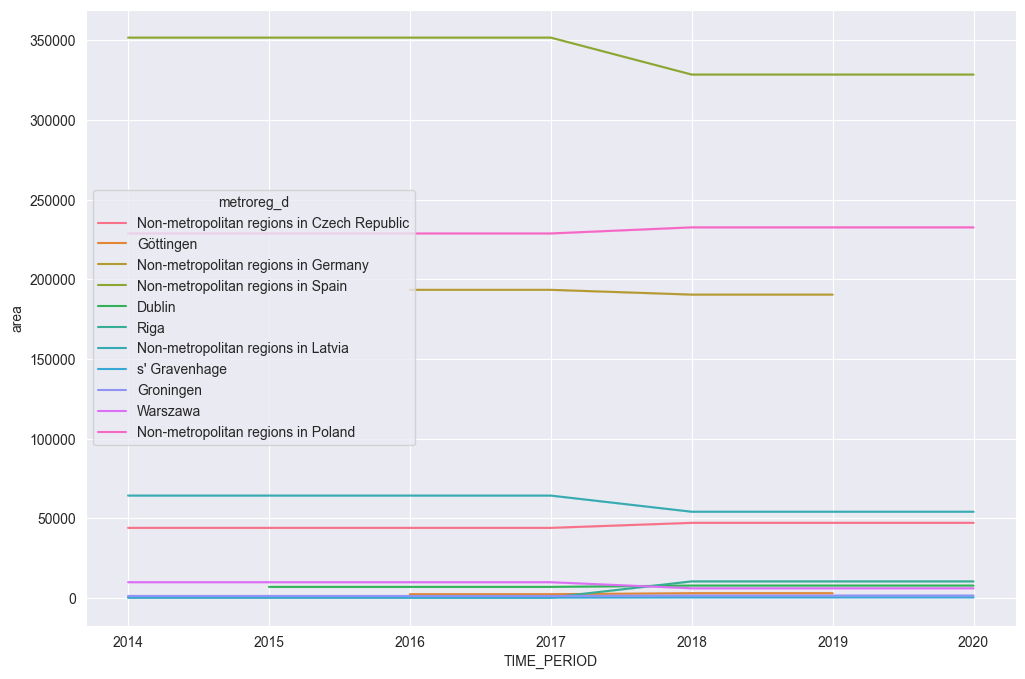

In [45]:
# List of metro regions where the area has changed over the years
plt.figure(figsize=(12, 8))
sns.lineplot(x='TIME_PERIOD', y='area', hue='metroreg_d', data=df[df['metroreg'].isin(metroregs_with_area_change)])

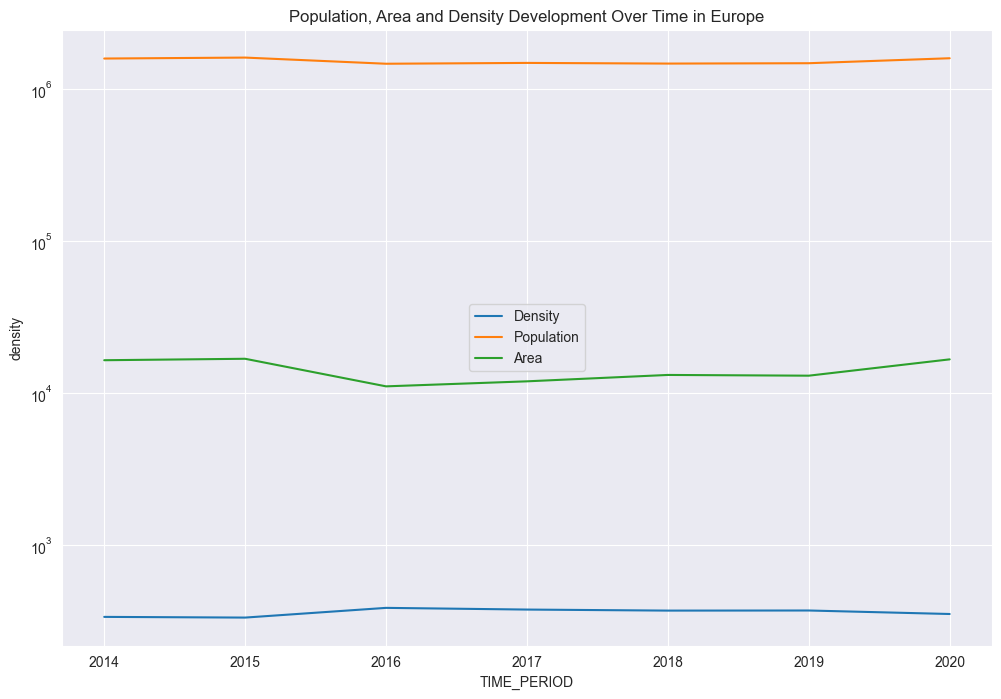

In [82]:
plt.figure(figsize=(12, 8))

# Calculate mean density, population, and area for each time period
density_mean = df.groupby('TIME_PERIOD')['density'].mean().reset_index()
population_mean = df.groupby('TIME_PERIOD')['population'].mean().reset_index()
area_mean = df.groupby('TIME_PERIOD')['area'].mean().reset_index()

# Plot mean density, population, and area over time
sns.lineplot(x='TIME_PERIOD', y='density', data=density_mean, label='Density')
sns.lineplot(x='TIME_PERIOD', y='population', data=population_mean, label='Population')
sns.lineplot(x='TIME_PERIOD', y='area', data=area_mean, label='Area')

plt.yscale('log')
plt.title('Population, Area and Density Development Over Time in Europe')
plt.legend()
plt.show()

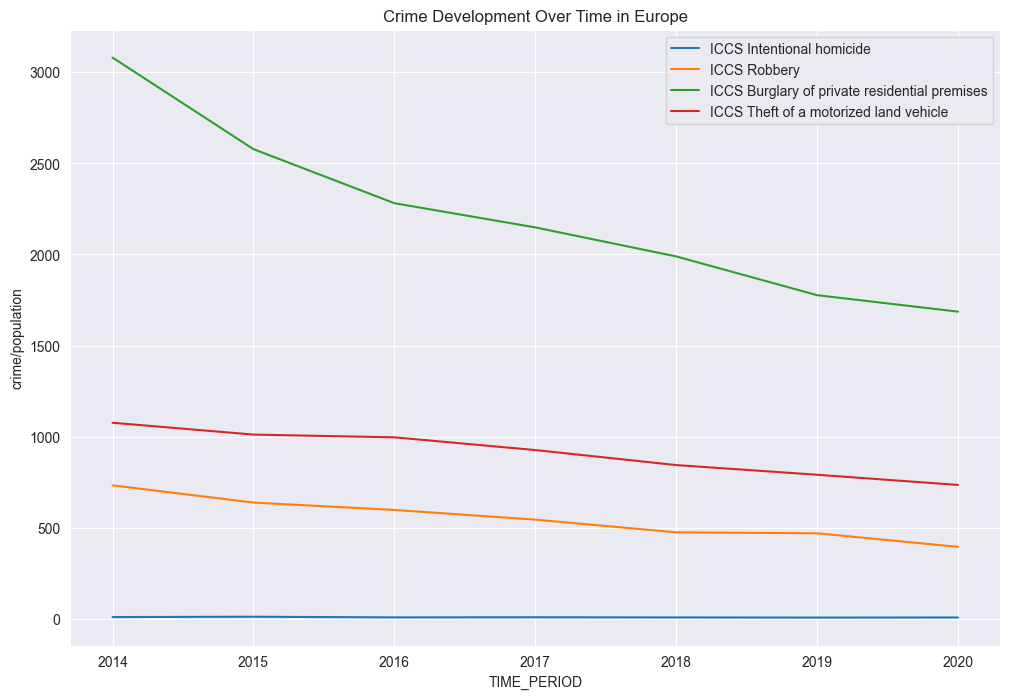

In [74]:
# development of crime in Europe over the years
plt.figure(figsize=(12, 8))
for crime in df['iccs_d'].unique():
    subset = df[df['iccs_d'] == crime]
    subset_mean = subset.groupby('TIME_PERIOD')['crime/population'].mean().reset_index()
    sns.lineplot(x='TIME_PERIOD', y='crime/population', data=subset_mean, label=f'ICCS {crime}')

plt.title('Crime Development Over Time in Europe')
plt.show()

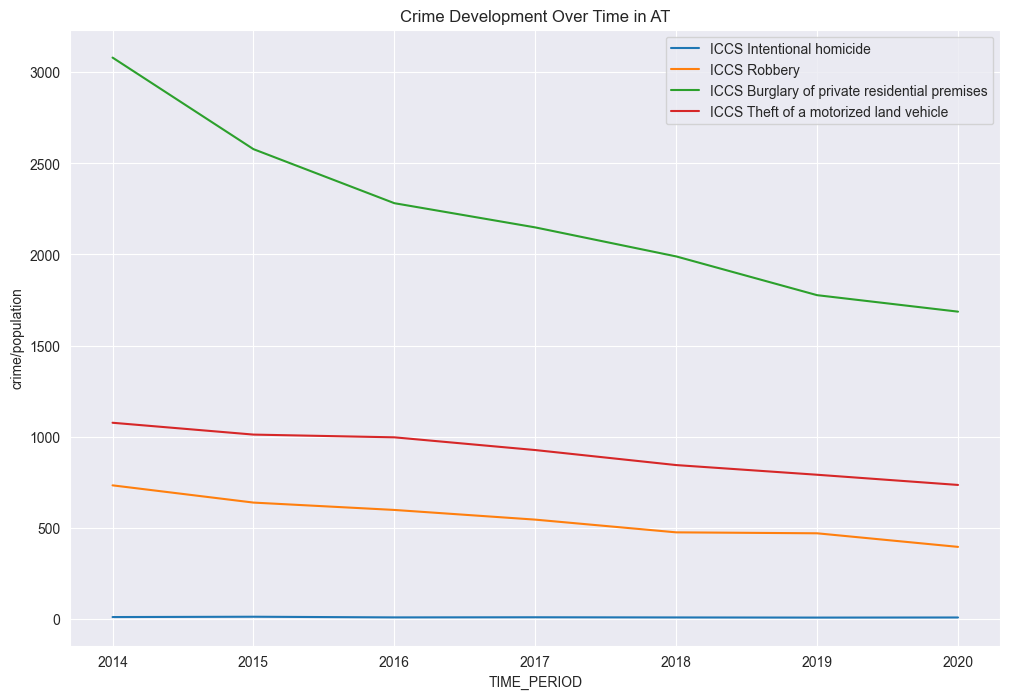

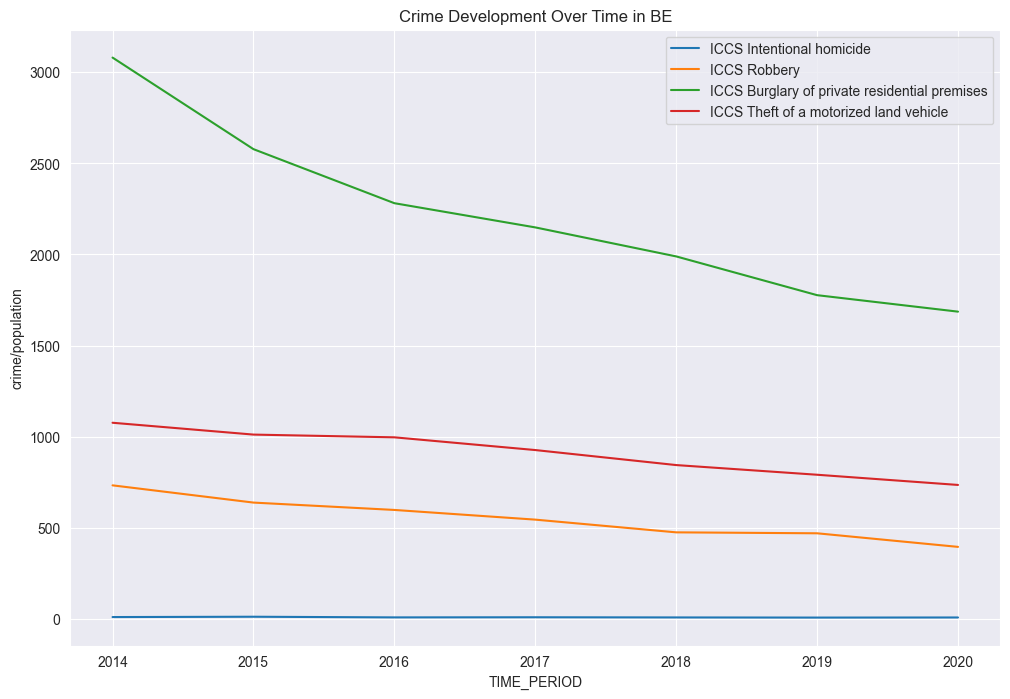

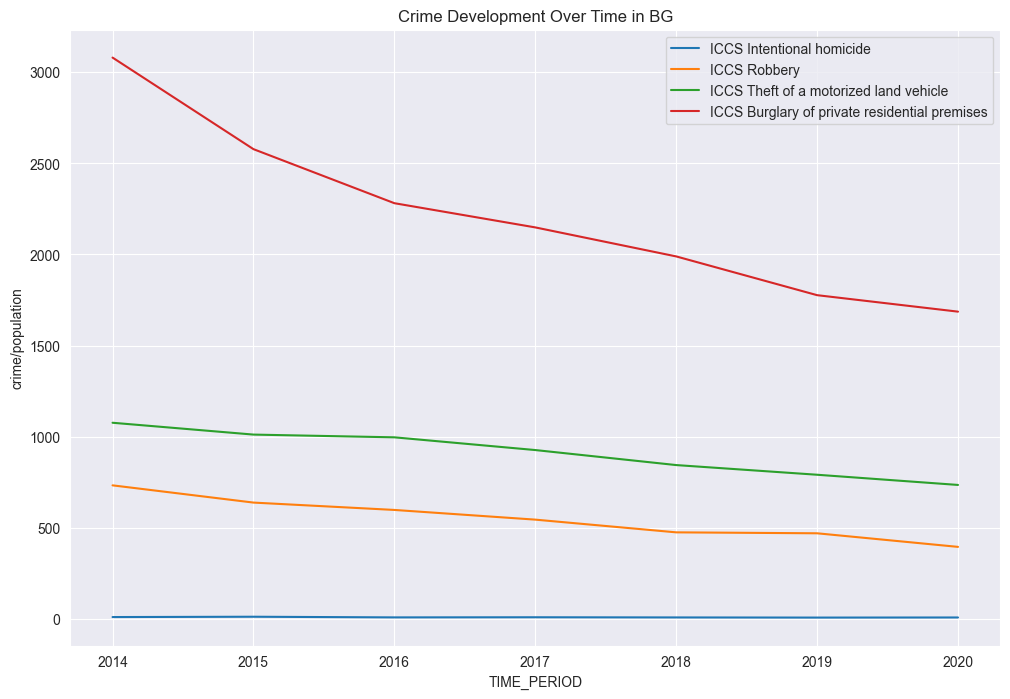

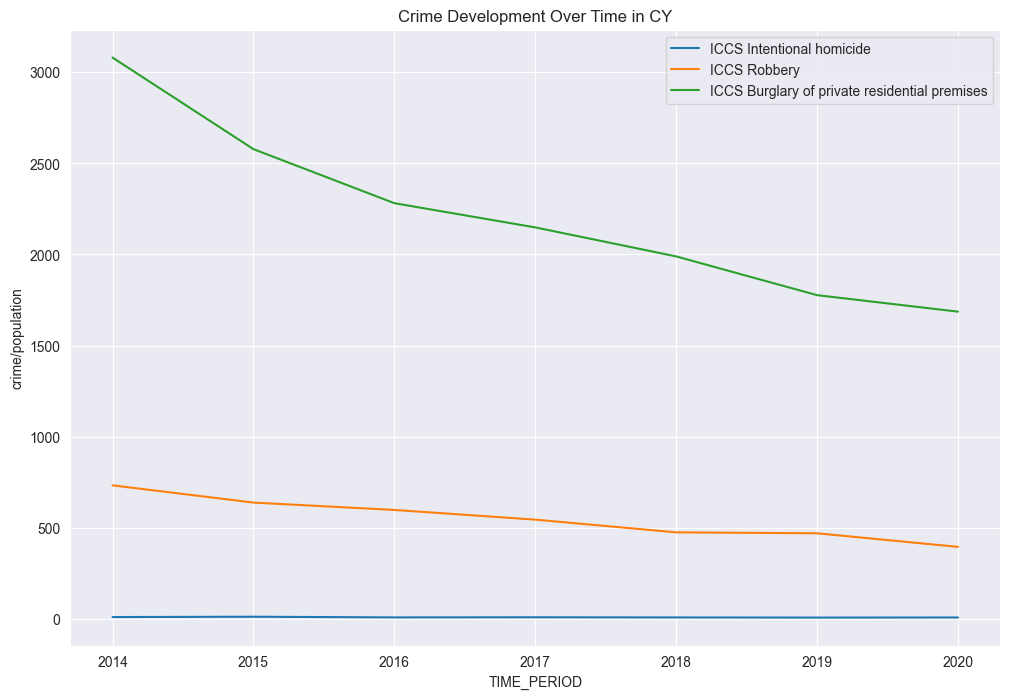

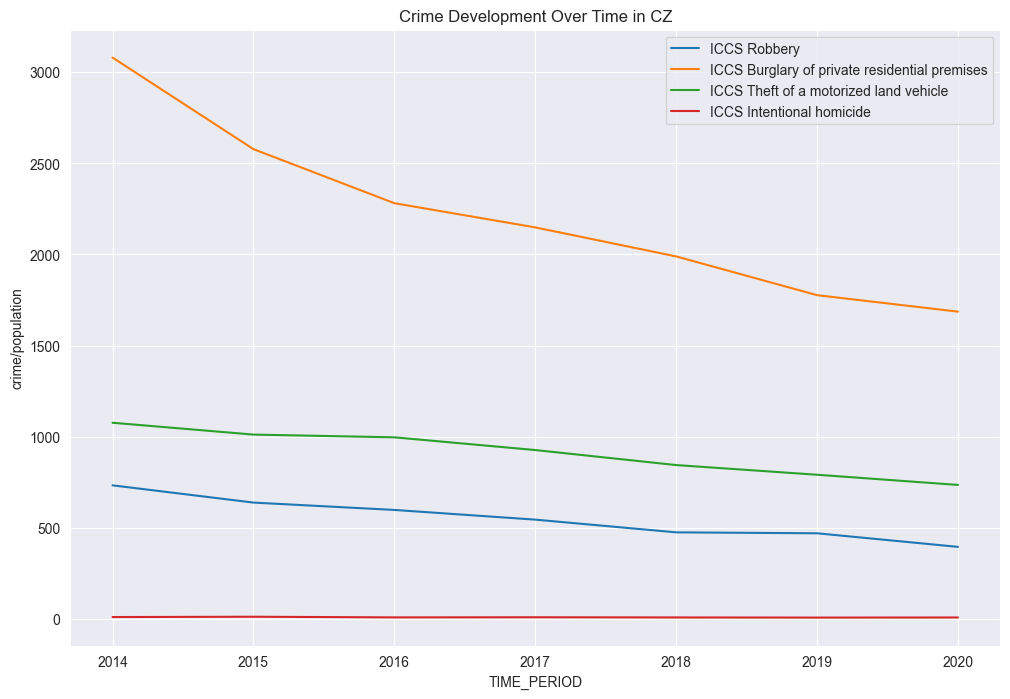

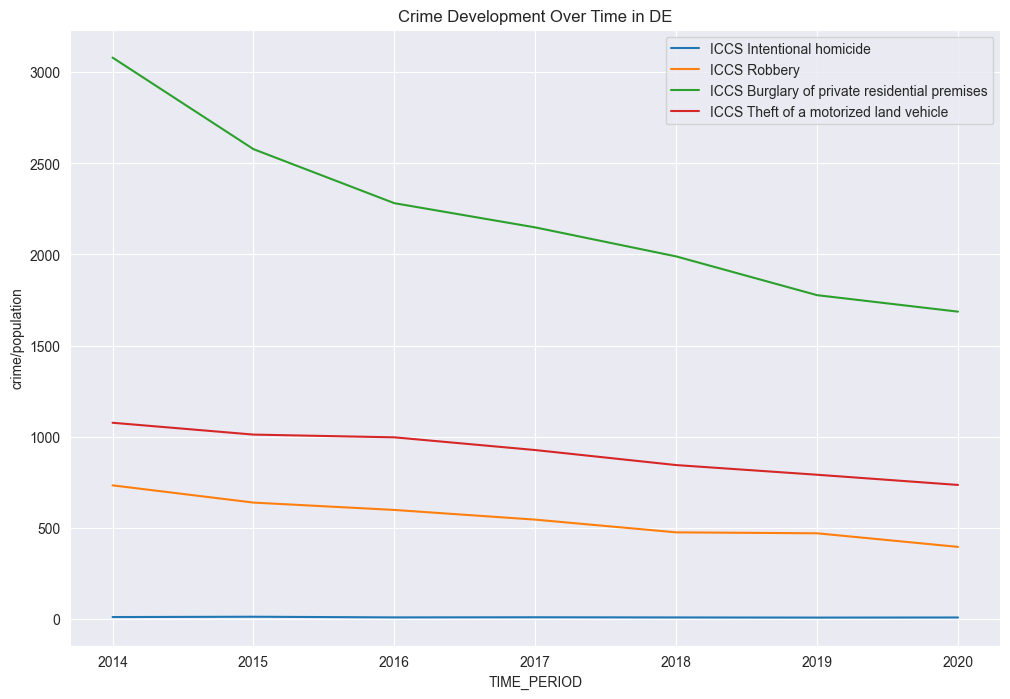

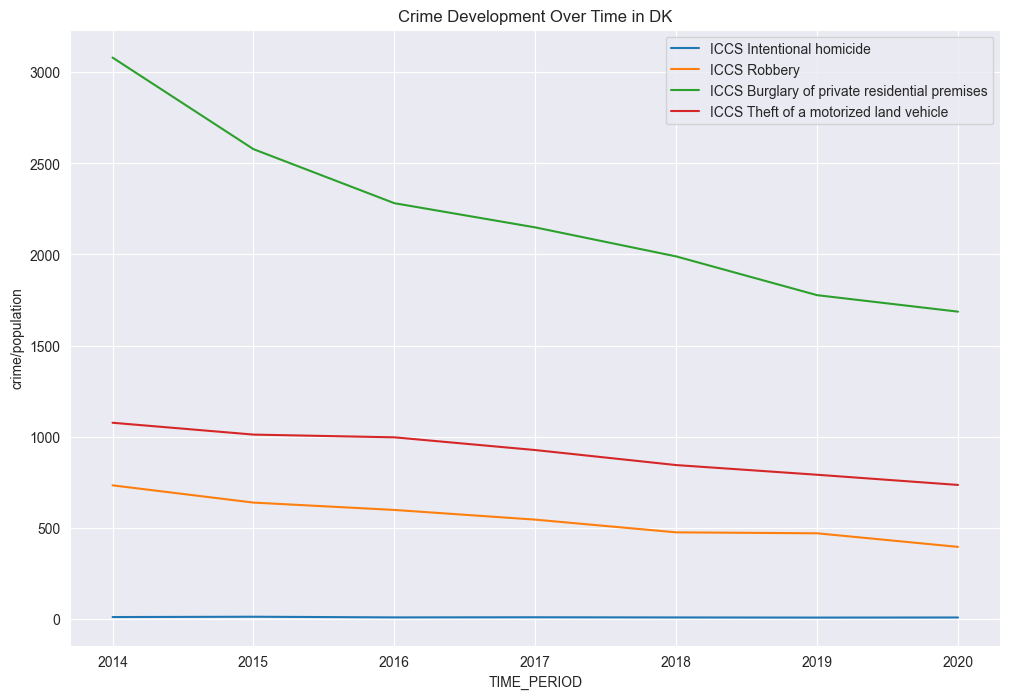

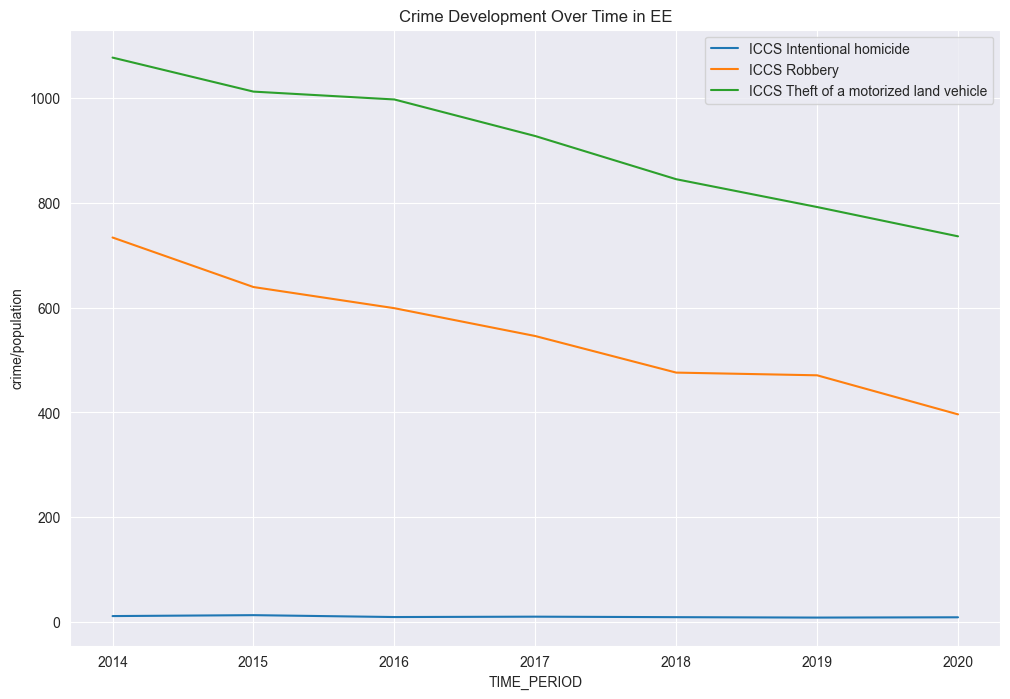

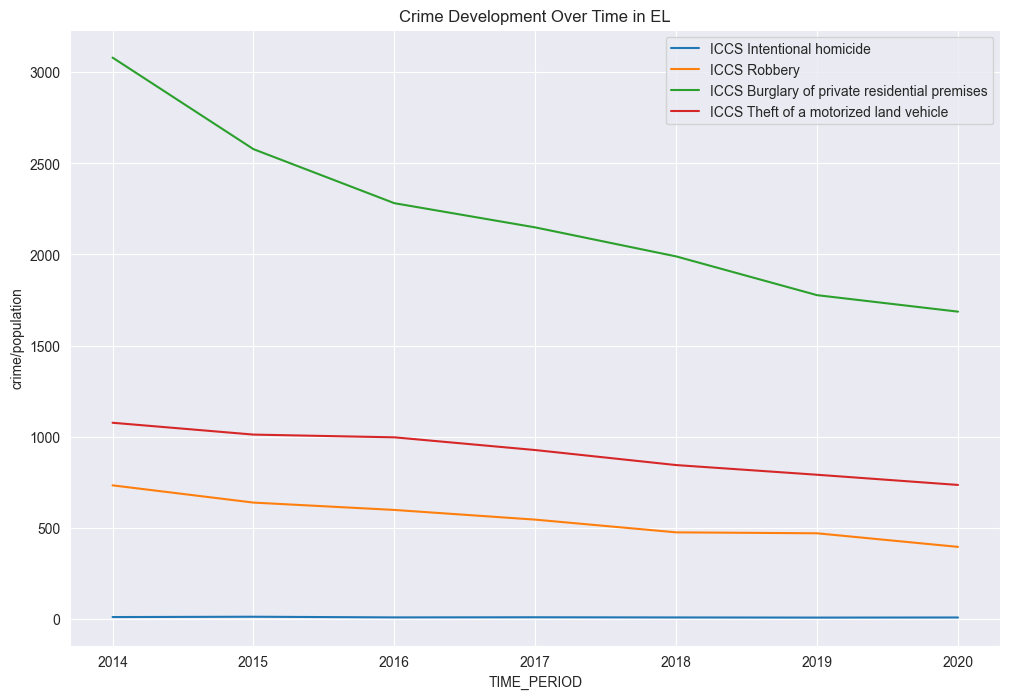

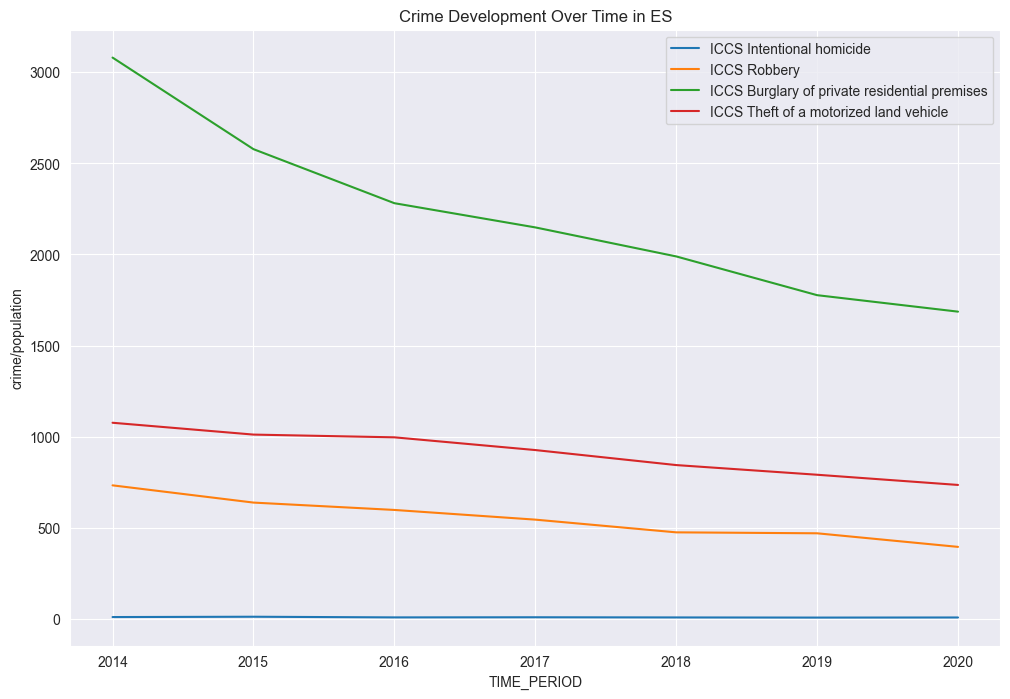

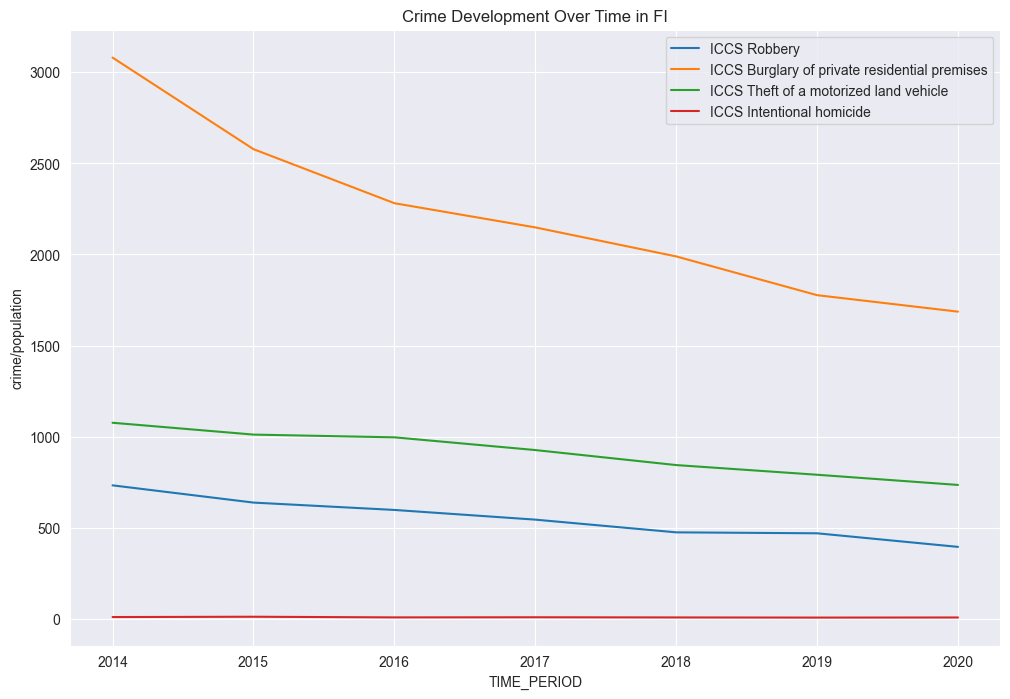

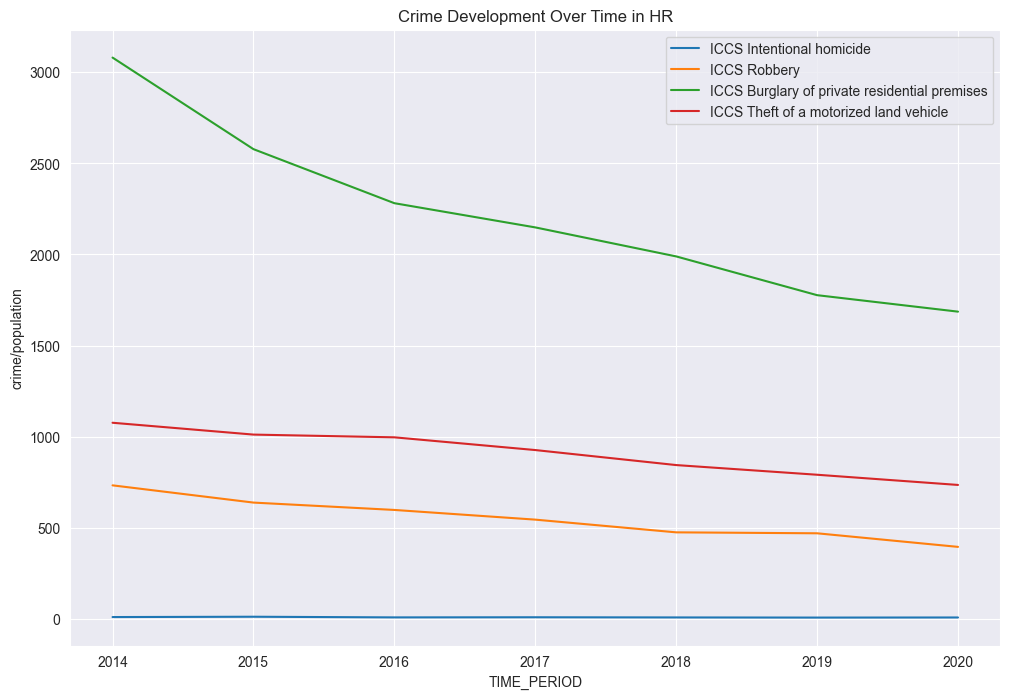

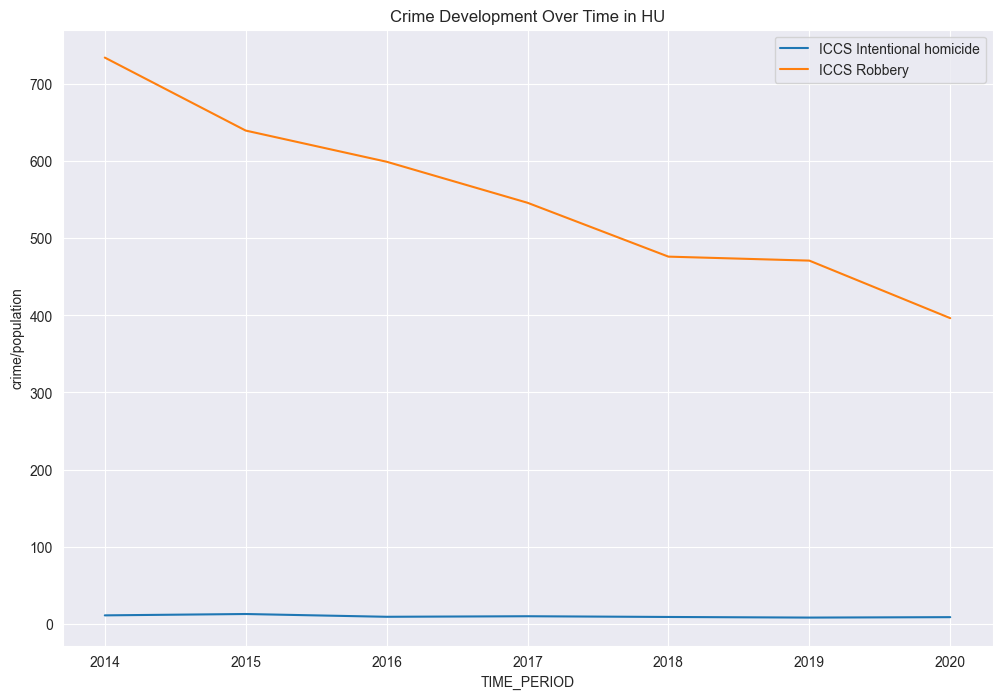

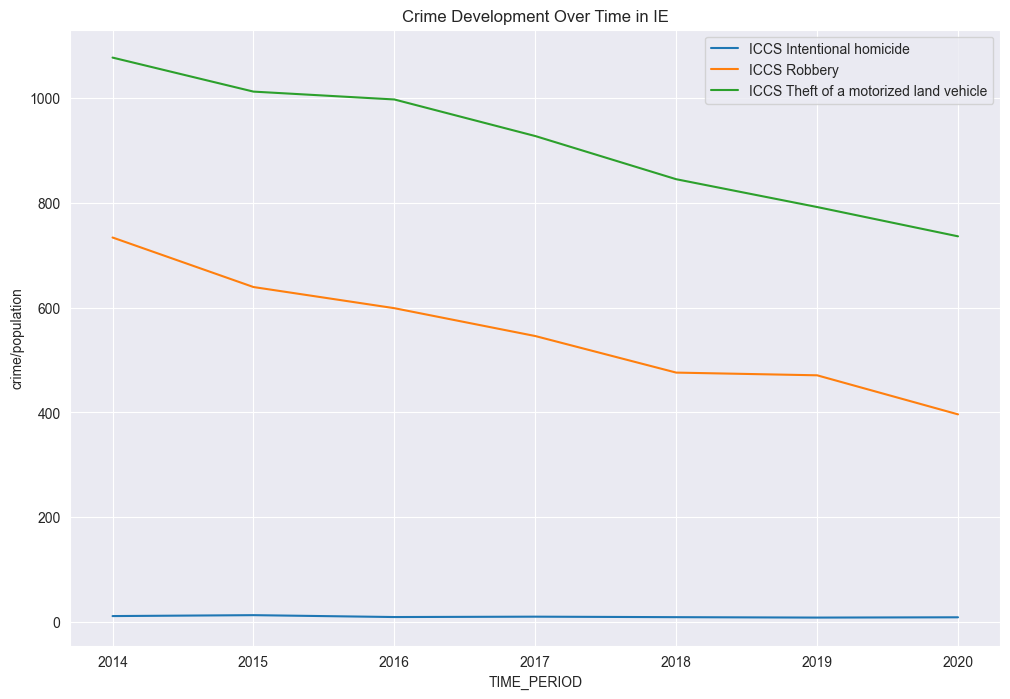

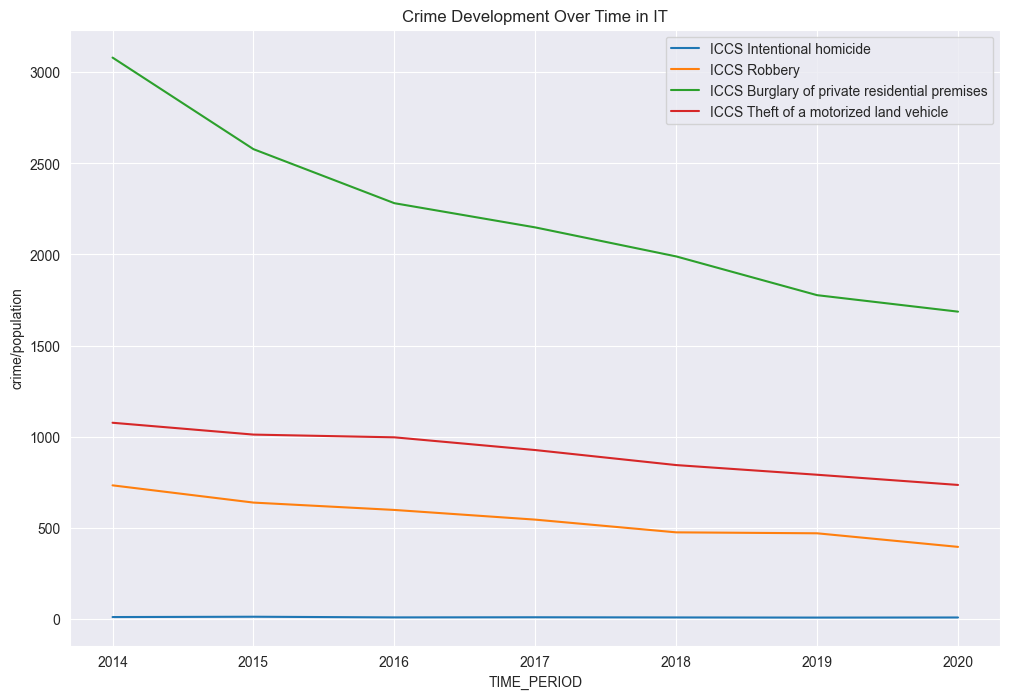

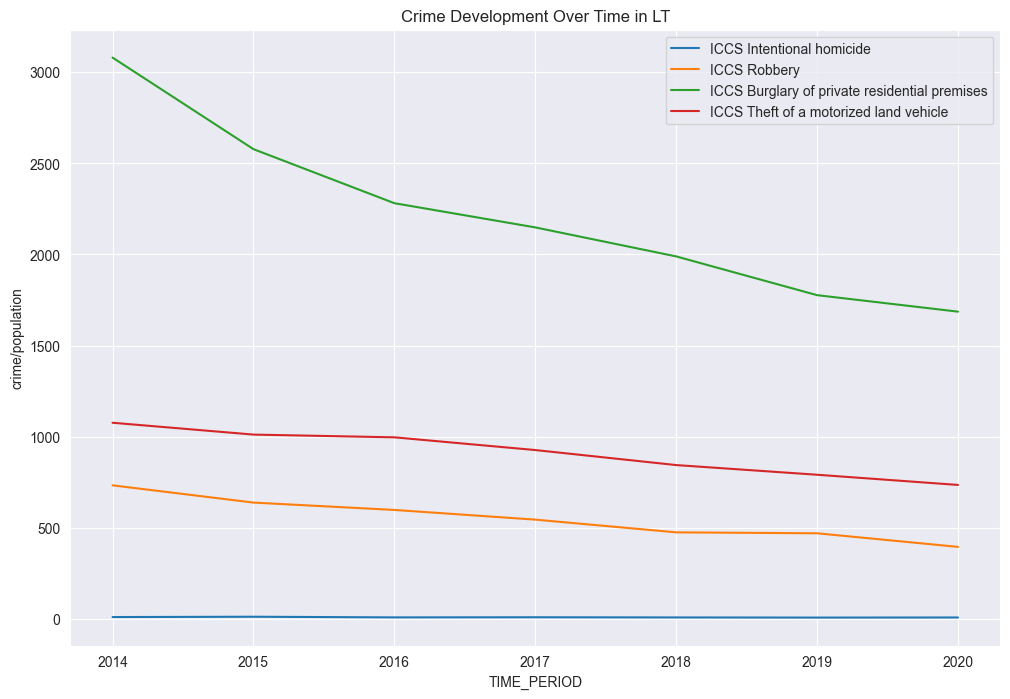

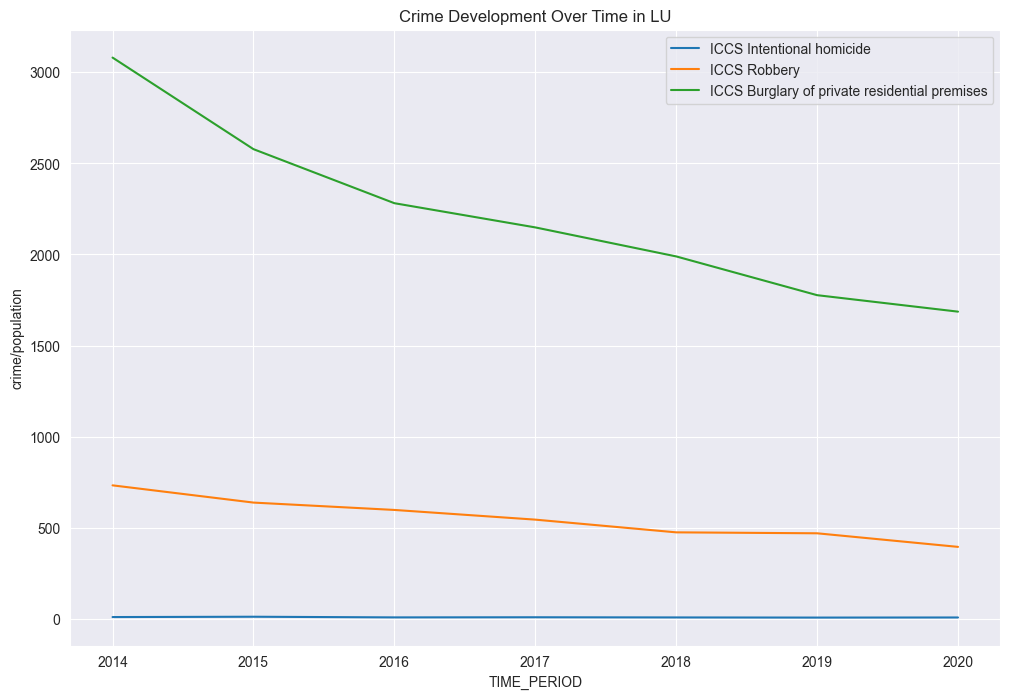

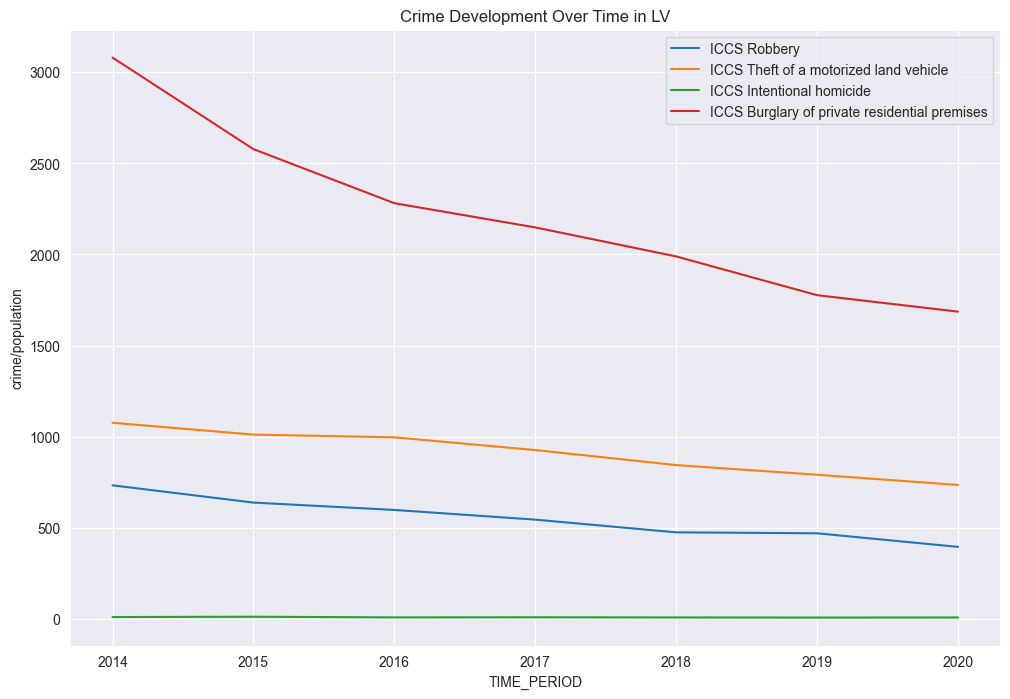

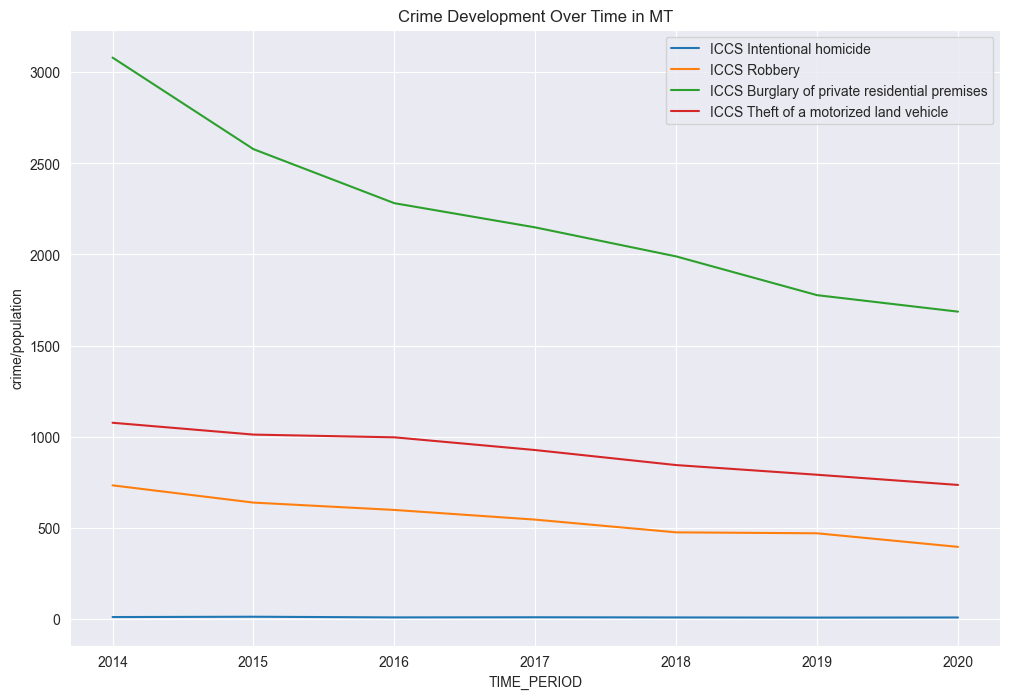

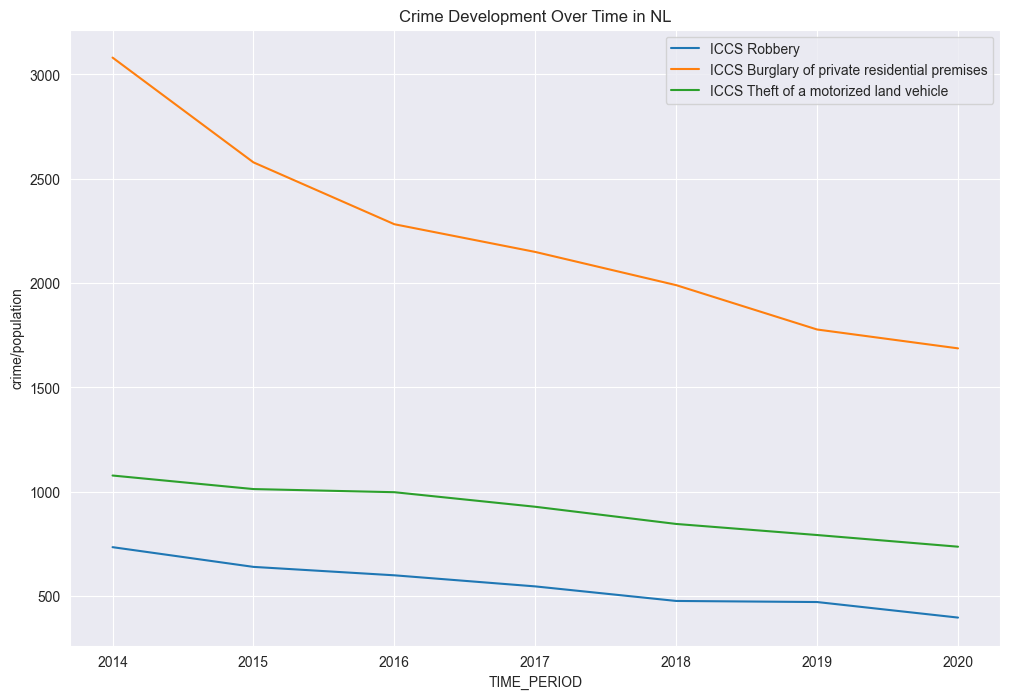

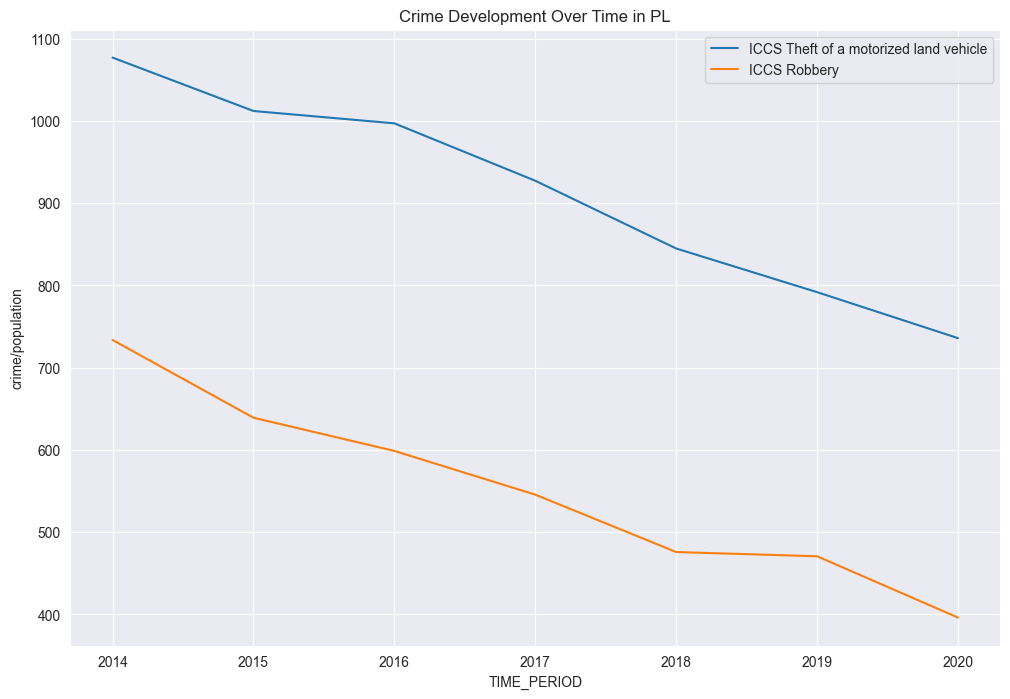

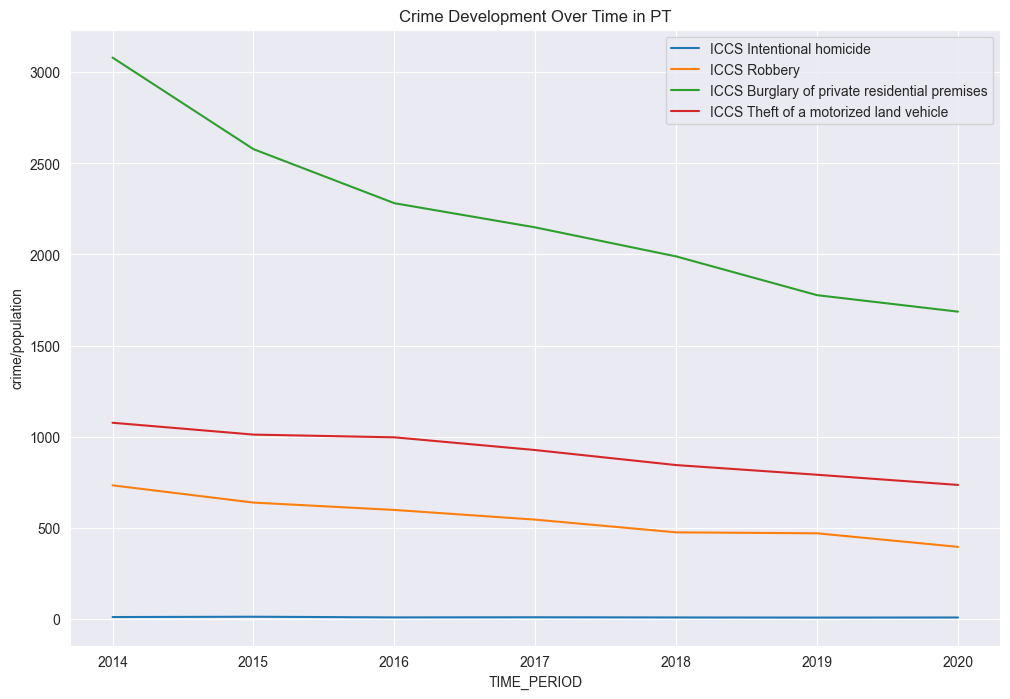

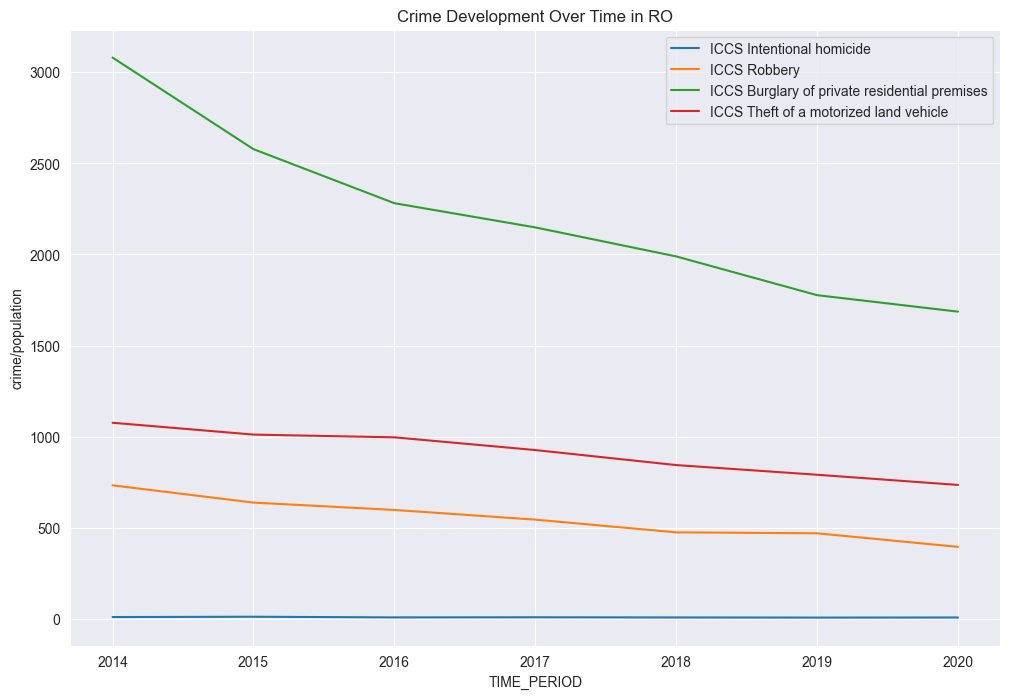

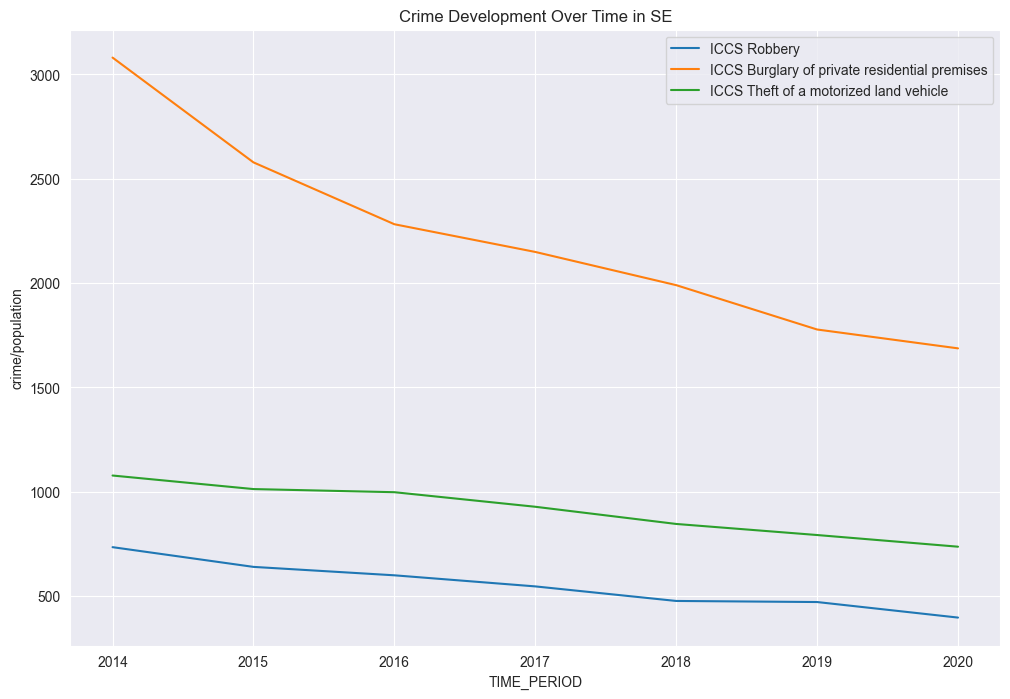

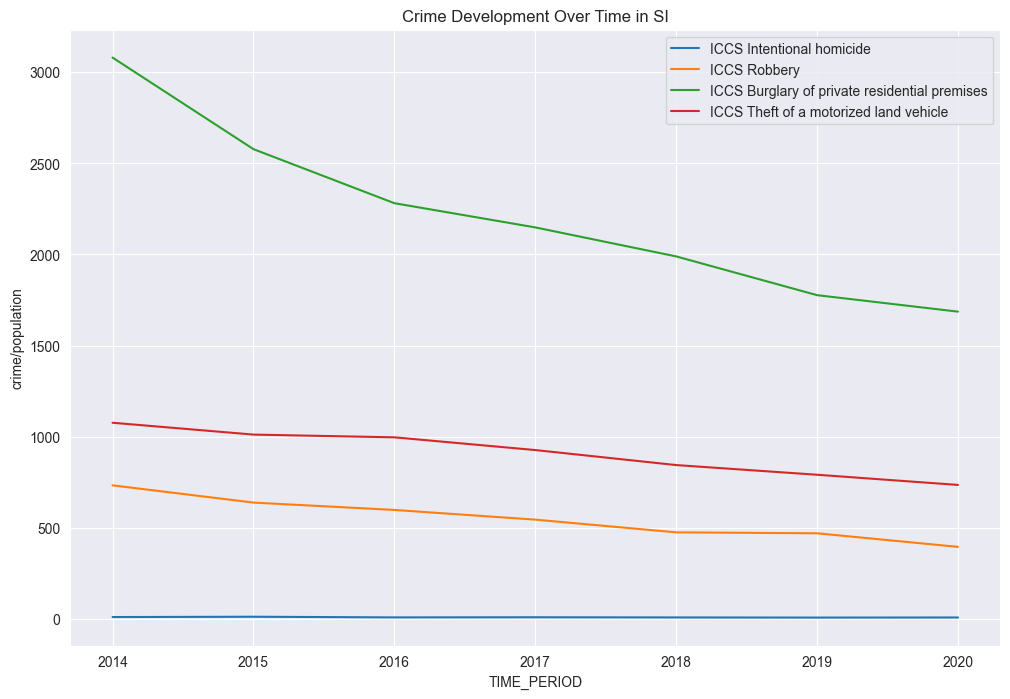

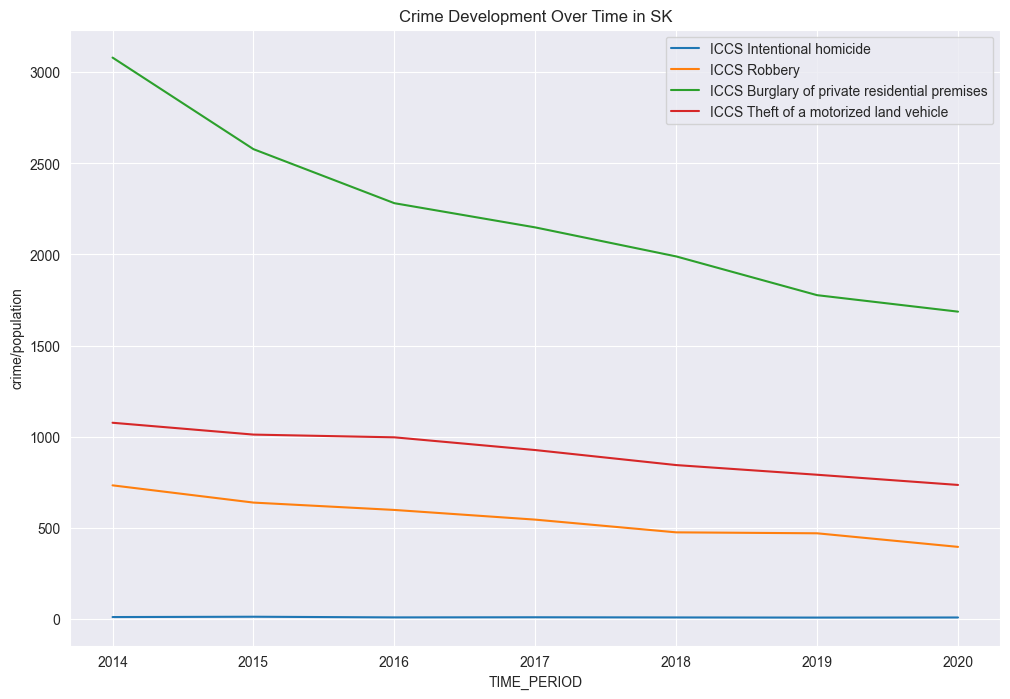

In [73]:
# general development of crime over the years by country
for country in df['country'].unique():
    plt.figure(figsize=(12, 8))
    df_country = df[df['country'] == country]
    for crime in df_country['iccs_d'].unique():
        subset = df[df['iccs_d'] == crime]
        subset_mean = subset.groupby('TIME_PERIOD')['crime/population'].mean().reset_index()
        sns.lineplot(x='TIME_PERIOD', y='crime/population', data=subset_mean, label=f'ICCS {crime}')

    plt.title(f'Crime Development Over Time in {country}')
    plt.legend()
    plt.show()